# Hand Gestures Capstone Project Prototype LSTM ML Model

The model below uses LSTM ML Model to learn patterns of normal, tremor, tonic, and postural phases in a epileptic seizure. The training CSV files are organized in a directory:<br>
data/<br>
├── normal/<br>
│   ├── normal1.csv<br>
│   └── normal2.csv<br>
├── tremor/<br>
│   ├── tremor1.csv<br>
│   └── tremor2.csv<br>
...<br>

And the files will be fed into the ML model to to final result of 4 categorical outputs of normal, tremor, tonic, and postural phases with varying probability.

In [32]:
label_map = {
    "normal": 0,
    "tremor": 1,
    "tonic": 2,
    "postural": 3
}

In [34]:
import os
import random
import shutil
from glob import glob

def split_train_val(train_dir, val_dir, split_ratio=0.1, seed=42):
    random.seed(seed)
    
    # Get all CSV files recursively
    all_csvs = glob(os.path.join(train_dir, '**', '*.CSV'), recursive=True)
    print(f"Found {len(all_csvs)} CSV files in {train_dir}")

    # Sample 10%
    val_csvs = random.sample(all_csvs, int(len(all_csvs) * split_ratio))

    for csv_path in val_csvs:
        # Determine relative path from the train_dir
        rel_path = os.path.relpath(csv_path, train_dir)
        target_path = os.path.join(val_dir, rel_path)

        # Create parent directories for the target path
        os.makedirs(os.path.dirname(target_path), exist_ok=True)

        # Move or copy file
        shutil.move(csv_path, target_path)  # or shutil.copy(csv_path, target_path)

    print(f"Moved {len(val_csvs)} files to {val_dir}")

# Usage
train_dir = 'train30-2'
val_dir = 'val30-2'
split_train_val(train_dir, val_dir, split_ratio=0.1)


Found 84 CSV files in train30-2
Moved 8 files to val30-2


In [41]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from pathlib import Path

class MotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        self._load_data(root_dir)

    def _load_data(self, root_dir):     
    
        root = Path(root_dir)

        # Iterate through each top-level class directory
        for class_dir in root.iterdir():
            if class_dir.is_dir():
                class_name = class_dir.name
                if class_name not in label_map:
                    continue  # Skip any unexpected folder
                # Get label index
                labelidx = label_map[class_name]
                # Initialize OneHot encoding
                label = [0, 0, 0, 0]
                # 
                if (labelidx >= 0 and labelidx <= 3):
                    # Fliping the index value to 1
                    label[labelidx] = 1
                else:
                    print("Label index is out of bounds: ", label)
                
                # Recursively find all CSV files under this class_dir
                for csv_file in class_dir.rglob("*.CSV"):
                    try:
                        df = pd.read_csv(csv_file)
                        data_tensor = torch.tensor(df.values, dtype=torch.float32)
                        self.samples.append((data_tensor, label))
                    except Exception as e:
                        print(f"Failed to load {file_path}: {e}")
                    
                    #File label
                    print("LABEL")
                    print(label)
                    print("TYPE:", type(label))
                    print('###')
        print("Sample Size ", len(self.samples))
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data, label = self.samples[idx]
        if self.transform:
            data = self.transform(data)
        return data, label


In [36]:
import torch.nn as nn

class SeizureLSTM(nn.Module):
    def __init__(self, input_size=9, hidden_size=64, num_layers=2, num_classes=4):
        super(SeizureLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Last time step
        out = self.fc(out)
        return out

In [37]:
class SeizureDataset(Dataset):
    def __init__(self, labeled_filepaths):
        self.samples = labeled_filepaths

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        csv_path, label = self.samples[idx]

        # Load CSV into tensor
        df = pd.read_csv(csv_path, header=None)
        data = torch.tensor(df.values, dtype=torch.float32)  # shape: [seq_len, features]
        # Turn label into tensor
        
        
        return data, label

In [38]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate_fn(batch):
    sequences, labels = zip(*batch)

    # Pad sequences to the same length
    padded_seqs = pad_sequence(sequences, batch_first=True)  # shape: [batch, max_len, features]
    labels = torch.tensor(labels, dtype=torch.long)
    
    return padded_seqs, labels


In [43]:
# VERSION 3
from torch.utils.data import DataLoader

def train(model, trainset, validset, epochs=50, batch_size=4, lr=0.001, verbose=True):
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)
    validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)


    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss, valid_loss, valid_accuracy = [], [], []

    for epoch in range(epochs):
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        total_valid_samples = 0
        
        model.train()
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            print("Outputs: ", outputs)
            print("y_batch: ", y_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
        train_loss.append(train_batch_loss / len(trainloader)) # Compute average training loss for this epoch
        
        
        # Validation
        model.eval() # Set the model to evaluation mode (disables dropout/batchnorm layers if any)
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                print("y (labels):", y)
                
                y_hat = model(X) # Forward pass: compute predictions for validation set
                print(y_hat)
                print('###')
                y_hat_labels = torch.argmax(y_hat, dim=1) # Apply sigmoid activation and classify outputs (threshold at 0.5)
                loss = criterion(y_hat, y.type(torch.long)) # Compute validation loss
                valid_batch_loss += loss.item() # Accumulate validation batch loss
                
                valid_batch_acc += (y_hat_labels == y).sum().item()
                print(valid_batch_acc)
                total_valid_samples += y.size(0) #  accuracy: compare predicted labels to actual label
                
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / total_valid_samples)
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results   


In [44]:
# Load dataset
trainset = MotionDataset(train_dir)
validset = MotionDataset(val_dir)

# Create model
model = SeizureLSTM(input_size=9, num_classes=4)  # assuming 4 classes: normal, tremor, tonic, posture

# Train
losses = train(model, trainset, validset)


LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 'list'>
###
LABEL
[0, 1, 0, 0]
TYPE: <class 

RuntimeError: Expected floating point type for target with class probabilities, got Long

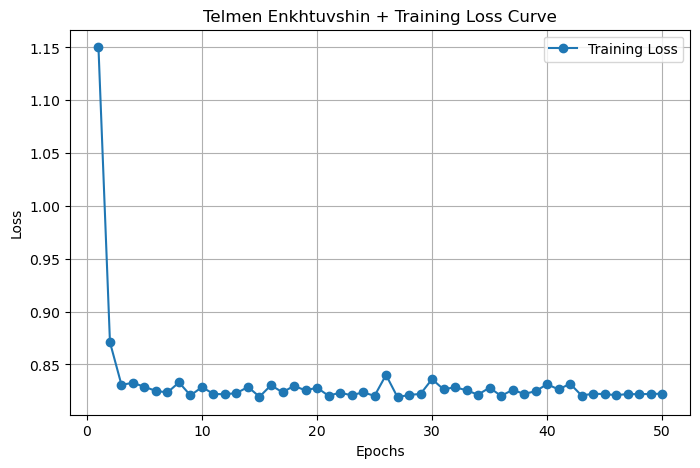

In [14]:
import matplotlib.pyplot as plt

# Extract metrics from the results dictionary
train_loss = losses["train_loss"]       # Training loss per epoch


# Plot Training and Validation Loss Curve
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss", marker='o')  # Training loss
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Telmen Enkhtuvshin + Training Loss Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()

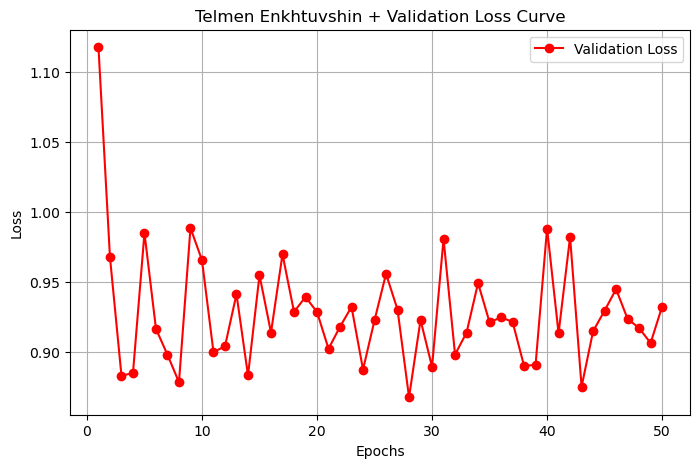

In [15]:
# Extract metrics from the results dictionary
valid_loss = losses["valid_loss"]       # Validation loss per epoch


# Plot Training and Validation Loss Curve
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(valid_loss) + 1), valid_loss, label="Validation Loss", marker='o', color="red")  # Validation loss
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Telmen Enkhtuvshin + Validation Loss Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()

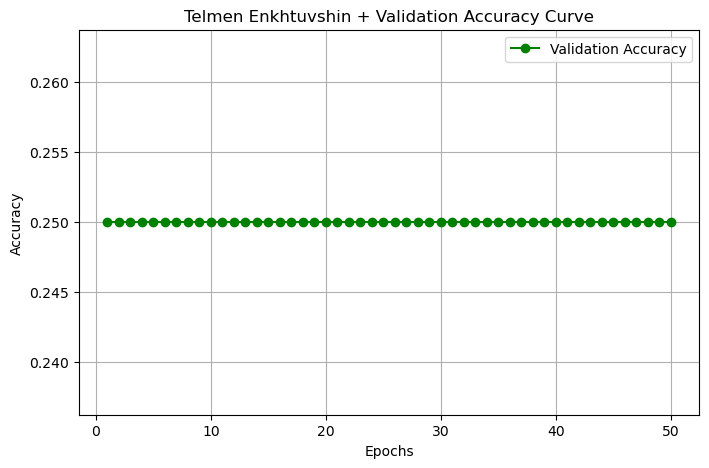

In [16]:
# Extract metrics from the results dictionary
valid_acc = losses["valid_accuracy"]       # Validation accuracy per epoch


# Plot Training and Validation Accuracy Curve
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(valid_acc) + 1), valid_acc, label="Validation Accuracy", marker='o', color="green")  # Validation Accuracy
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Accuracy")  # Y-axis label
plt.title("Telmen Enkhtuvshin + Validation Accuracy Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()

In [17]:
valid_acc

[0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25]

In [12]:
from pathlib import Path
import pandas as pd

# Define root directory and target filename
root_dir = Path("train/normal/walking")
target_name = "Telmen1-051425.CSV"

# Search for the file
for file in root_dir.rglob("*.CSV"):
    if file.name == target_name:
        df_normalWalk = pd.read_csv(file)
        break
else:
    raise FileNotFoundError(f"{target_name} not found in {root_dir}")
    
df_normalWalk.head()

,Timestamp(ms),AccelX(g),AccelY(g),AccelZ(g),GyroX(deg/s),GyroY(deg/s),GyroZ(deg/s),DistanceLeft(cm),DistanceRight(cm)
0,17992,-0.174,0.113,0.974,7.550,1.718,-2.260,0.0,57.0
1,18048,-0.183,0.091,0.964,3.031,4.122,-4.374,0.0,57.0
2,18099,-0.187,0.103,0.986,4.275,4.038,-4.824,0.0,57.0
3,18154,-0.172,0.138,0.998,6.573,4.008,-3.779,0.0,57.0
4,18206,-0.185,0.089,1.011,1.679,2.282,-2.023,0.0,57.0


# Walking data Analysis

### Accelerometer

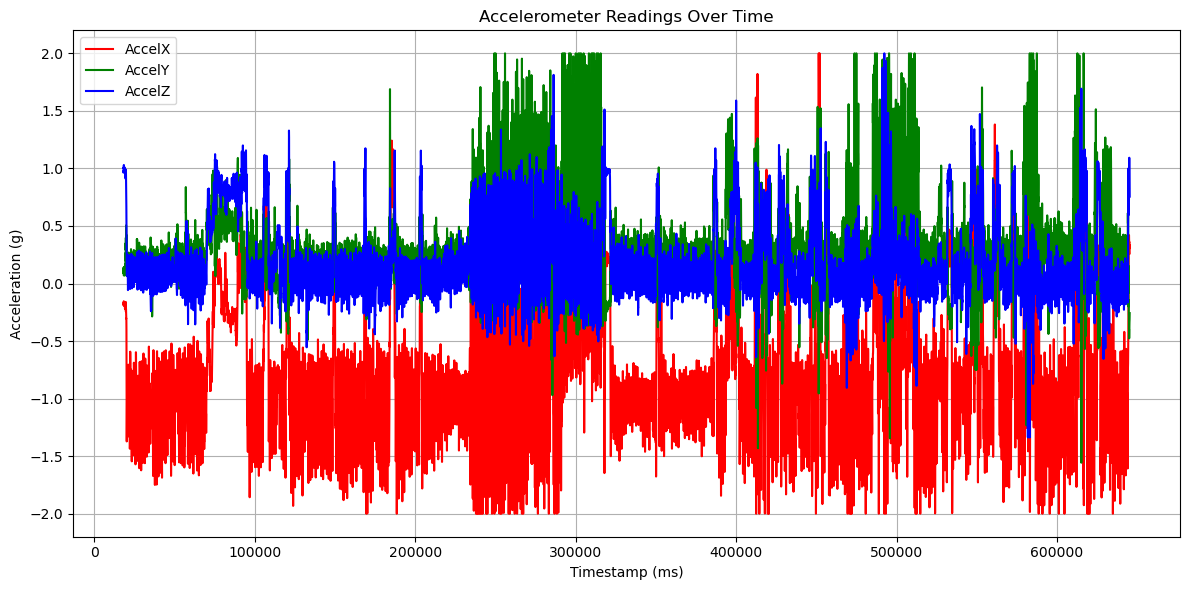

In [46]:
import matplotlib.pyplot as plt

# Plotting AccelX, AccelY, AccelZ against Timestamp(ms)
plt.figure(figsize=(12, 6))
plt.plot(df_normalWalk["Timestamp(ms)"], df_normalWalk["AccelX(g)"], label="AccelX", color="red")
plt.plot(df_normalWalk["Timestamp(ms)"], df_normalWalk["AccelY(g)"], label="AccelY", color="green")
plt.plot(df_normalWalk["Timestamp(ms)"], df_normalWalk["AccelZ(g)"], label="AccelZ", color="blue")

plt.title("Accelerometer Readings Over Time")
plt.xlabel("Timestamp (ms)")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

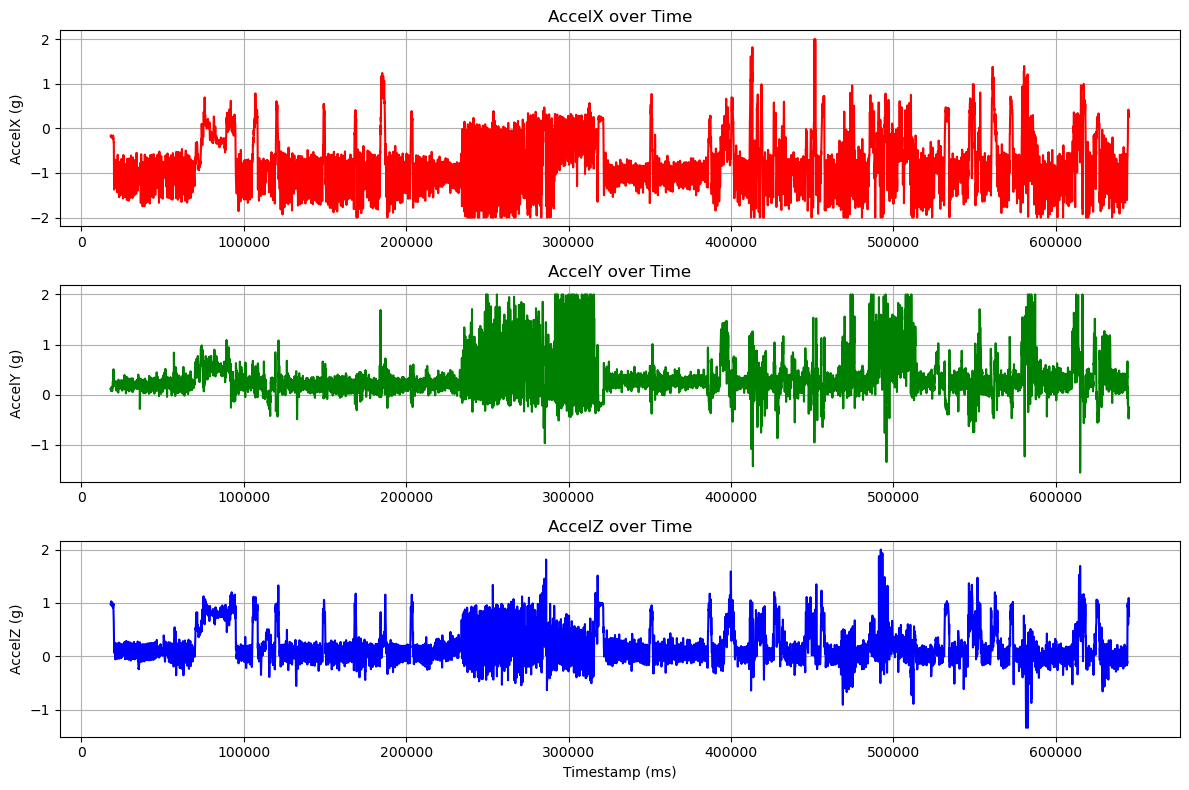

In [47]:
# Create subplots
plt.figure(figsize=(12, 8))

# Plot AccelX
plt.subplot(3, 1, 1)
plt.plot(df_normalWalk["Timestamp(ms)"], df_normalWalk["AccelX(g)"], color='red')
plt.title("AccelX over Time")
plt.ylabel("AccelX (g)")
plt.grid(True)

# Plot AccelY
plt.subplot(3, 1, 2)
plt.plot(df_normalWalk["Timestamp(ms)"], df_normalWalk["AccelY(g)"], color='green')
plt.title("AccelY over Time")
plt.ylabel("AccelY (g)")
plt.grid(True)

# Plot AccelZ
plt.subplot(3, 1, 3)
plt.plot(df_normalWalk["Timestamp(ms)"], df_normalWalk["AccelZ(g)"], color='blue')
plt.title("AccelZ over Time")
plt.xlabel("Timestamp (ms)")
plt.ylabel("AccelZ (g)")
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


### Gyroscope

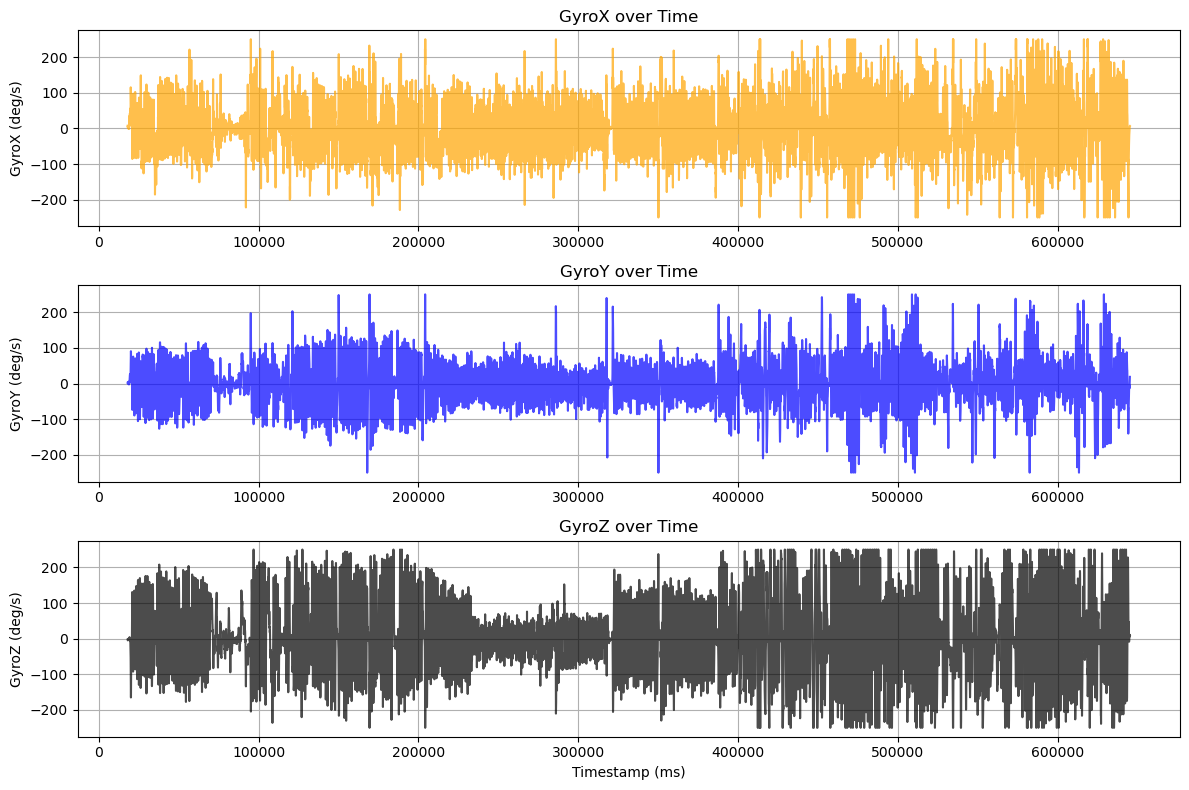

In [52]:
# Create subplots
plt.figure(figsize=(12, 8))

# Plot AccelX
plt.subplot(3, 1, 1)
plt.plot(df_normalWalk["Timestamp(ms)"], df_normalWalk["GyroX(deg/s)"], color='orange', alpha=0.7)
plt.title("GyroX over Time")
plt.ylabel("GyroX (deg/s)")
plt.grid(True)

# Plot AccelY
plt.subplot(3, 1, 2)
plt.plot(df_normalWalk["Timestamp(ms)"], df_normalWalk["GyroY(deg/s)"], color='blue', alpha=0.7)
plt.title("GyroY over Time")
plt.ylabel("GyroY (deg/s)")
plt.grid(True)

# Plot AccelZ
plt.subplot(3, 1, 3)
plt.plot(df_normalWalk["Timestamp(ms)"], df_normalWalk["GyroZ(deg/s)"], color='black', alpha=0.7)
plt.title("GyroZ over Time")
plt.xlabel("Timestamp (ms)")
plt.ylabel("GyroZ (deg/s)")
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()
